## Initializing the experiment

First, create the 'common' part of the dyngen simulations as follows. This will ensure that the gene regulatory network part of the simulation is exactly the same.

In [1]:
library(dyno)
library(slurmR)
library(dyngen)
library(parallel)
library(dynutils)
library(tidyverse)
library(assertthat)
library(data.table)
library(SingleCellExperiment)
source("../scripts/perturbation.R")
source("../scripts/backbone_cellpop.R")

set.seed(1)
data("realcounts", package = "dyngen")

Loading required package: dynfeature

Loading required package: dynguidelines

Loading required package: dynmethods

Loading required package: dynplot

Loading required package: dynwrap

Loading required package: parallel

slurmR default option for `tmp_path` (used to store auxiliar files) set to:
  /mnt/scratcha/fmlab/baker02/tidyscreen/notebooks
You can change this and checkout other slurmR options using: ?opts_slurmR, or you could just type "opts_slurmR" on the terminal.

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.1     ✔ dplyr   1.0.6
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘assertthat’


The following object is masked from ‘package:tibble’:

    has_name



Attaching package: ‘data.tab

In [6]:
backbone <- backbone_bifurcating()

config = initialise_model(
            backbone = backbone,
            num_cells = 1000,
            num_targets = 500,
            num_hks = 500,
            verbose = interactive(),
            download_cache_dir = tools::R_user_dir("dyngen", "data"),
            simulation_params = simulation_default(
              total_time = 1000,
              census_interval = 2, 
              ssa_algorithm = ssa_etl(tau = 300/3600),
              experiment_params = simulation_type_wild_type(num_simulations = 10)
            ),
            experiment_params = experiment_snapshot(
              realcount = "GSE100866_CBMC_8K_13AB_10X-RNA_umi"
            )
          )

In [2]:
# backbone <- backbone_bifurcating()

# config <-
#   initialise_model(
#     backbone = backbone,
#     num_cells = 1000,
#     num_tfs = nrow(backbone$module_info),
#     num_targets = 250,
#     num_hks = 250,
#     simulation_params = simulation_default(
#       census_interval = 10, 
#       ssa_algorithm = ssa_etl(tau = 300 / 3600),
#       experiment_params = simulation_type_wild_type(num_simulations = 100)
#     )
#   )

In [7]:
model_common = config %>%
                  generate_tf_network() %>%
                  generate_feature_network() %>% 
                  generate_kinetics() %>%
                  generate_gold_standard()

## Simulate Wild Type

Simulating the wild type is to simply run the standard dyngen way of simulating cells

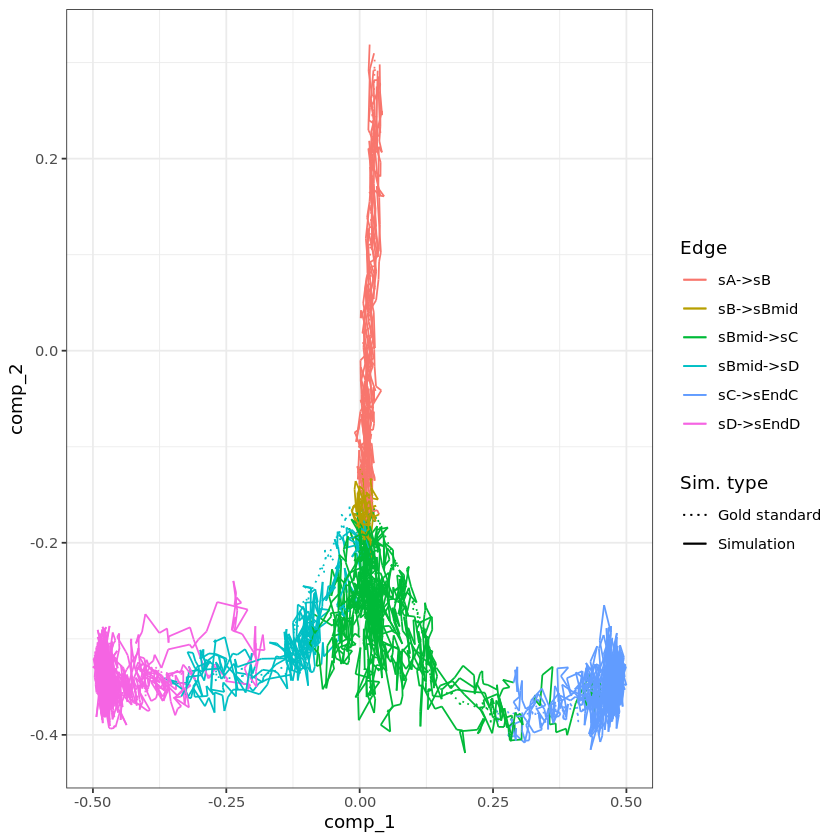

In [8]:
model_wt = model_common %>% generate_cells()
plot_gold_mappings(model_wt, do_facet = FALSE)

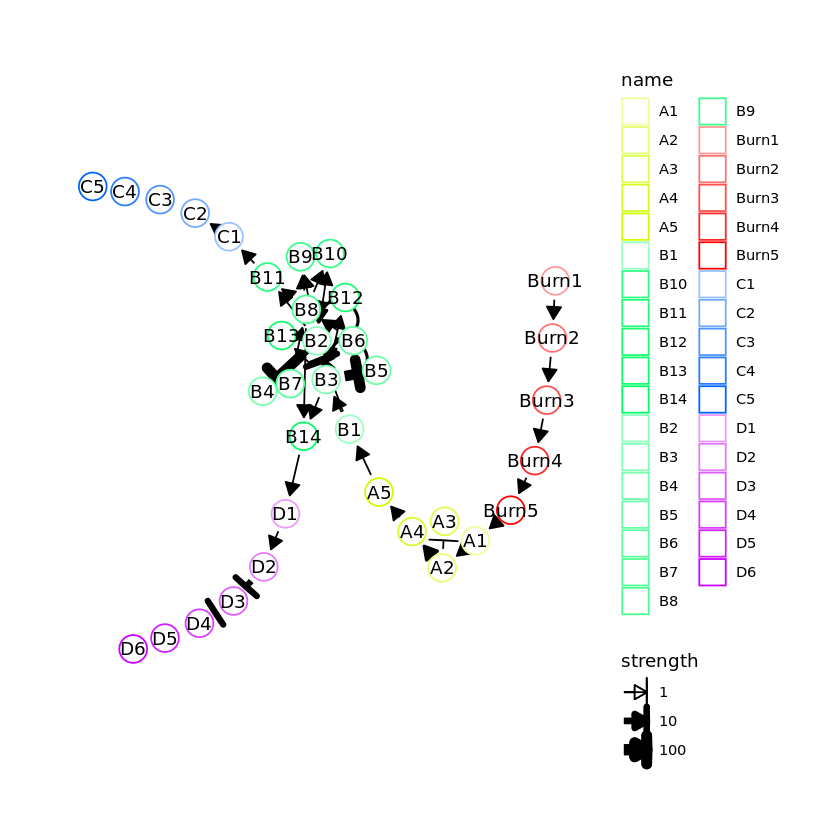

In [9]:
plot_backbone_modulenet(model_common)

## Simulate Knockout

To simulate a gene knockout, the experiment type of the simulation is changed from the wild type to knockdown. The **simulation_type_knockdown** function is actually designed to perform single-cell knockdowns of 1 to 5 random genes by default! But this behavior can be overriden by setting the following parameters:

- **genes**: list of gene ids to be knocked out
- **num_genes**: number of genes to be knocked out per gene (sampled randomly)
- **multiplier**: the fraction of the transcription rate after KO (0 = no transcription, 1 = no Knockout)

In [10]:
b3_genes = model_common$feature_info %>% filter(module_id == "B3") %>% pull(feature_id)
model_ko = model_common

model_ko$simulation_params$experiment_params = simulation_type_knockdown(
  num_simulations = 100L,
  timepoint = 0, 
  genes = b3_genes,
  num_genes = length(b3_genes),
  multiplier = 0
)

Warning message in .generate_cells_predict_state(model):
“Simulation does not contain all gold standard edges. This simulation likely suffers from bad kinetics; choose a different seed and rerun.”


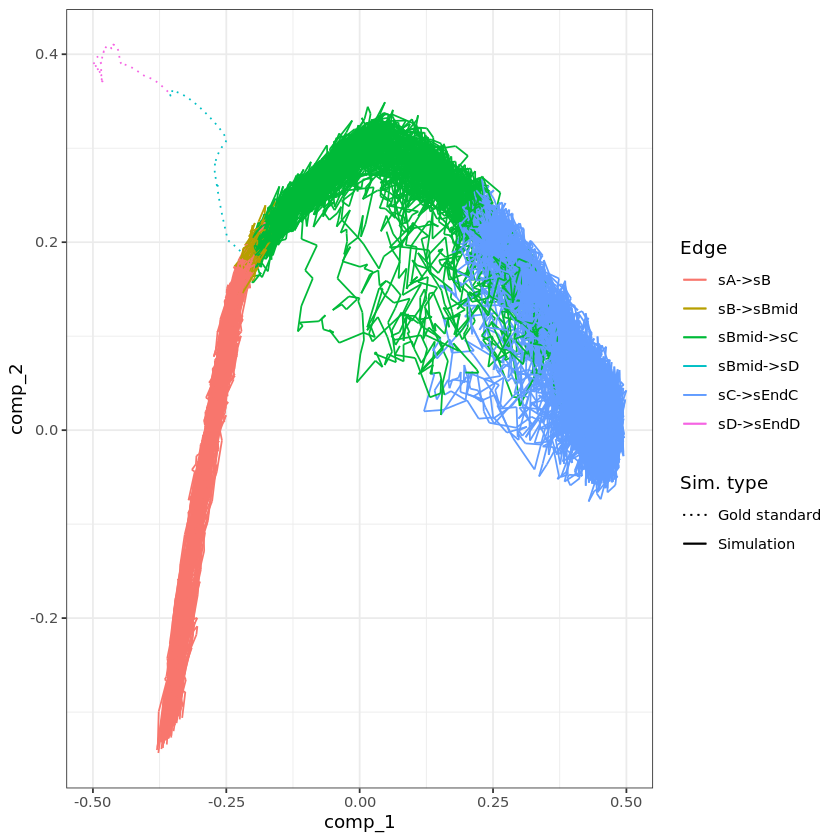

In [11]:
model_ko = model_ko %>% generate_cells()
plot_gold_mappings(model_ko, do_facet = FALSE)

## Combine Outputs and Visualise

We can combine both simulations into one simulation and visualize the output.

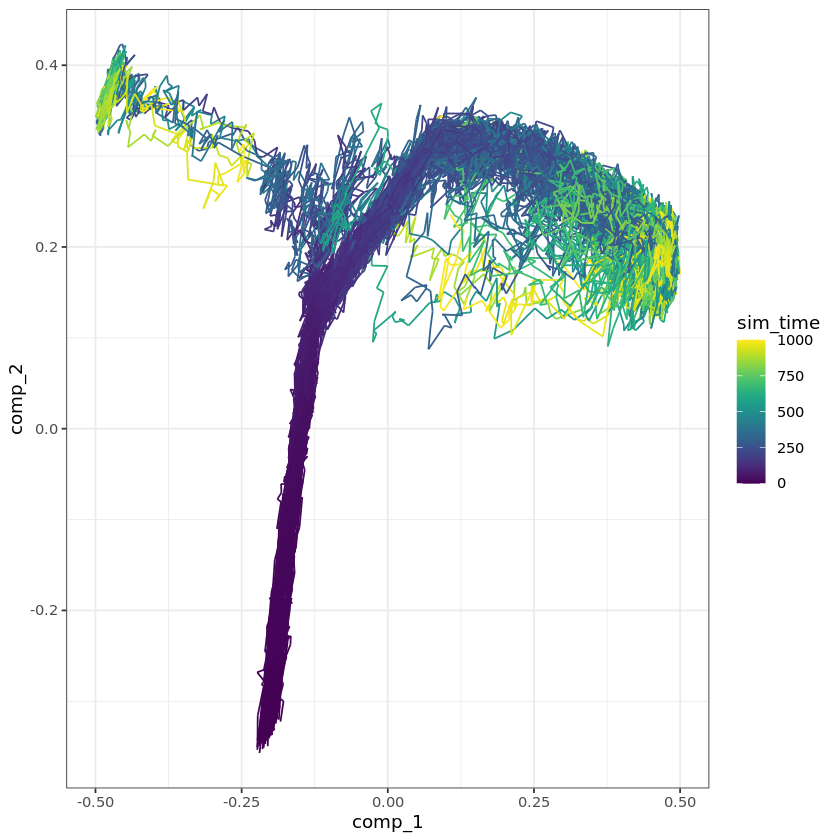

In [12]:
model_comb = combine_models(list(WT = model_wt, KO1 = model_ko)) %>% generate_experiment()
plot_simulations(model_comb)

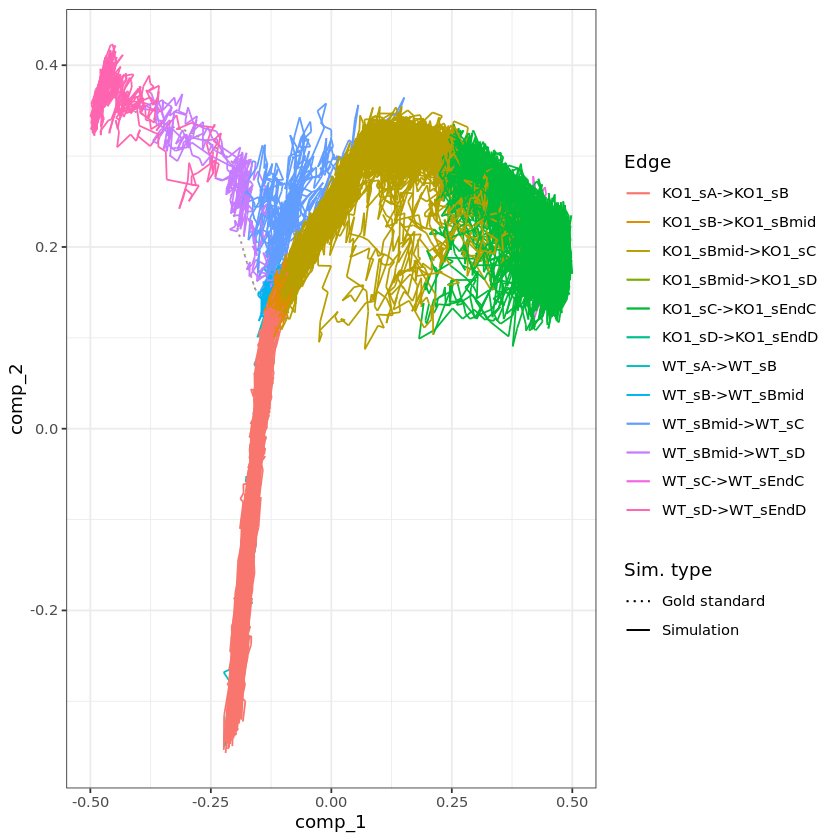

In [13]:
plot_gold_mappings(model_comb, do_facet = FALSE)